# don't enter to this part,just run it!!

## import liberary and esential functions

In [ ]:
#@title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from google.colab import drive
import scipy.io
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


بخش استخراج داده  های پروژه از فایل های DPX

%%HTML
<div dir=rtl>
تابع اصلی اما برای استخراج داده های فایل های متلب تابع زیر یعنی DPXD  خواهد بود که خروجی آن یک دیکشنری با فیلد های زیر که تایپ آن نیز ذکر شده خواهد بود لذا برای استفاده اسان تر از داده ها از ابتدا فایل مربوطه را به تابع داده و از دیکشنری خروجی استفاده نمایید.
 <ul>
  <li>speeds : Numpy Array</li>
  <li>Id of Mouse: List </li>
  <li>Type of experiment: List</li>
  <li>Diameter of Points(Diams): Numpy Array </li>
  <li>Contrast of Points(Contrast) : Numpy Array </li>
</ul> 
</div>

In [ ]:
#@title
def DPXD2Dict(f):
  p=f['C'][0,0]
  p1=p[0,0]
  size=p1[8][0][0]
  Id=[]
  Type=[]
  SpeedSign=[]
  Speed=p1[2][0]
  Yaw=[]
  Time=[]
  BAYASYAW=[]
  diam=p1[5][0]
  contrast=p1[6][0]
  std_level=[]
  for i in range(size):
    temp=p1[3][0][i][0].split("_")
    Id.append(temp[0])
    Type.append(temp[1])    
    if(Speed[i]==0):
      SpeedSign.append("sta")
    elif(Speed[i]<0):
      SpeedSign.append("neg")
    else:
      SpeedSign.append("pos")  
    Yaw.append(p1[7][0][i][0])
    Time.append(p1[1][0][i][0])
    BAYASYAW.append(p1[0][0][i][0])
    std_level.append(np.std(p1[7][0][i][0]))  
  data={"YAW":Yaw,"YAW_BAYAS":BAYASYAW,"YAW_Time":Time,"YAW_std_level":std_level,
        "speeds":Speed,"Id":Id,"Type":Type,"SignSpeed":SpeedSign,'Diams':diam,'Contrast':contrast}
  return data      

## load file

In [ ]:
#@title
data={}
l=[[7,14,21],[8,15,22],[7,14,21],[8,16,23],[8,15,22]]

for i in range(len(l)):
  for j in range(1,l[i][2]+1):
    f=scipy.io.loadmat('/content/drive/My Drive/mouseProject/Speed/mouseNewData/W{}/{}.mat'.format(i+1,j))
    if(j<=l[i][0]):
      data[('W{}_BOTH'.format(i+1),j)]=DPXD2Dict(f)
    elif(j>l[i][0] and j<=l[i][1]):
      data[('W{}_LEFT'.format(i+1),j)]=DPXD2Dict(f)
    else:
      data[('W{}_RIGHT'.format(i+1),j)]=DPXD2Dict(f)

## converting the input


In [ ]:
def minSize(l):
  t=1500
  for i in l:
    if(i.shape[0]<t):
      t=i.shape[0]
  return t 
#=========---------------------
def create_dict(l):
  my_dict={}
  for i in l:
    for j in l:
      my_dict[(i,j)]=[]

  return my_dict

def compare_cluster(types=['W1_BOTH'],ID=[3],ID_start=[0],threshold=10): # please add one type of mouce
  l=np.unique(data[('W1_BOTH',ID[0])]['speeds']) #check exist all speed
  single_mean_dict,Yaw_mean_dict,Yaw_mean_dict_Time = create_dict(l),create_dict(l),create_dict(l)
  
  p=-1
  for mouce_type in types:
    p+=1
    for w in range(1+ID_start[p],ID[p]+1+ID_start[p]):
      for i in range(1,data[(mouce_type,w)]['speeds'].shape[0]):
        # ignore outlier
        if data[(mouce_type,w)]['YAW_std_level'][i]> threshold and data[(mouce_type,w)]['YAW_std_level'][i-1]> threshold:   
          single_mean_dict[(data[(mouce_type,w)]['speeds'][i-1],data[(mouce_type,w)]['speeds'][i])].append(np.mean(data[(mouce_type,w)]['YAW'][i]))
          Yaw_mean_dict[(data[(mouce_type,w)]['speeds'][i-1],data[(mouce_type,w)]['speeds'][i])].append(data[(mouce_type,w)]['YAW'][i])
          Yaw_mean_dict_Time[(data[(mouce_type,w)]['speeds'][i-1],data[(mouce_type,w)]['speeds'][i])].append(data[(mouce_type,w)]['YAW_Time'][i])
  
  return Yaw_mean_dict_Time,Yaw_mean_dict,l
def find_standard_yaw(Yaw_mean_dict_Time,Yaw_mean_dict,l):

   #used to find first quadratics in order to have longer trials
  quadratics=create_dict(l)
  quadraticsVal=create_dict(l)
  for i in l:
    for j in l:
      quadratics[(i,j)]=(len(Yaw_mean_dict_Time[(i,j)])//4)
  for i in l:
    for j in l:
      temp=[]
      for k in range(len(Yaw_mean_dict_Time[(i,j)])):
        temp.append(Yaw_mean_dict_Time[(i,j)][k].shape[0])
      temp.sort()
      quadraticsVal[(i,j)]=temp[quadratics[(i,j)]]
  edited_yaw=create_dict(l)
  edited_time=create_dict(l)
  for i in l:
    for j in l:
      for k in range(len(Yaw_mean_dict_Time[(i,j)])):
        if(Yaw_mean_dict_Time[(i,j)][k].shape[0]>=quadraticsVal[(i,j)]):
          edited_yaw[(i,j)].append(Yaw_mean_dict[(i,j)][k])
          edited_time[(i,j)].append(Yaw_mean_dict_Time[(i,j)][k])
  Yaw_mean_dict=edited_yaw
  Yaw_mean_dict_Time=edited_time
  return Yaw_mean_dict

In [ ]:
a,b,l=compare_cluster(['W1_BOTH','W2_BOTH','W3_BOTH','W4_BOTH','W5_BOTH'],[7,8,7,8,8],[0,0,0,0,0])
Yaw_mean_dict_BOTH =find_standard_yaw(a,b,l)

a,b,l=compare_cluster(['W1_LEFT','W2_LEFT','W3_LEFT','W4_LEFT','W5_LEFT'],[7,7,7,8,7],[7,8,7,8,8])
Yaw_mean_dict_LEFT =find_standard_yaw(a,b,l)

a,b,l=compare_cluster(['W1_RIGHT','W2_RIGHT','W3_RIGHT','W4_RIGHT','W5_RIGHT'],[7,7,7,7,7],[14,15,14,16,15])
Yaw_mean_dict_RIGHT =find_standard_yaw(a,b,l)

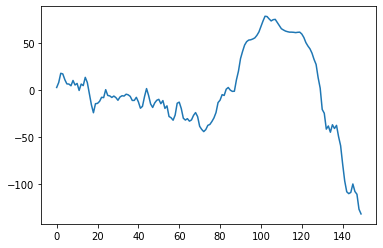

In [ ]:
plt.plot(Yaw_mean_dict_BOTH[(+72, -72)][0])

#Creating DataSet


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
from torchvision import transforms

In [ ]:
transform = transforms.Compose([
    
    transforms.Normalize(mean=[0], std=[1])
])

In [ ]:
class MouseDataset(torch.utils.data.Dataset):
  def __init__(self,transform = transform):
    self.transform=transform

  def make_data_set(self,data, types = ['BOTH','LEFT','RIGHT'], mice = [i+1 for i in range(5)]):
    l = [[7,14,21],[8,15,22],[7,14,21],[8,16,23],[8,15,22]]
    alltrials = []
    allspeeds = []
    nums = []
    for mouse in mice:
      for typ in types:
        if typ == 'BOTH':
          num = 0
      
        elif typ == 'LEFT':
          num = 1
          
        else:
          num = 2
        
        start = l[mouse-1][num-1]+1  if num != 0 else 1       
        for j in range(start,l[mouse-1][num]+1):
          alltrials.extend(data[(f'W{str(mouse)}_{typ}', j)]['YAW'])
          allspeeds.extend(data[(f'W{str(mouse)}_{typ}', j)]['SignSpeed'])
          nums.extend([num for i in range(len(data[(f'W{str(mouse)}_{typ}', j)]['YAW']))])
      enc = OneHotEncoder()


      self.X = self.truncate(alltrials,nums) 
      t = np.array(allspeeds)
      b = t[:,np. newaxis]
      self.Y = enc.fit_transform(b).toarray()

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, index):
    
    return self.X[index,:], self.Y[index,:]

  def truncate(self,alltrials,nums):
    max_length = max([arr.shape[0] for arr in alltrials])
    for i in range(len(alltrials)):
      alltrials[i] = np.pad(alltrials[i], (0, max_length - len(alltrials[i])), 'constant')
      # alltrials[i] = np.pad(alltrials[i], (nums[i], 0), 'constant')
    output_array = np.array(alltrials)
    return output_array

In [ ]:
mouseDs = MouseDataset()
mouseDs.make_data_set(data)


In [ ]:
train_size = int(0.8 * len(mouseDs))
test_size = len(mouseDs) - train_size
train_dataset, test_dataset = random_split(mouseDs, [train_size, test_size])

In [ ]:
batch_size = 64
hidden_dim = 128
learning_rate = 0.001
epochs = 10

In [ ]:
mouseDs[0]

(array([ 24.15      ,  14.65      ,   3.48333333,  -6.35      ,
        -11.85      ,  -4.01666667,  11.81666667,  10.48333333,
         19.31666667,   8.98333333,   6.31666667,  13.81666667,
          9.31666667,  11.81666667,  -1.18333333,  10.48333333,
          9.81666667,   7.81666667,   4.81666667,   4.31666667,
         -3.85      , -13.01666667, -25.18333333, -18.01666667,
        -16.68333333, -17.51666667, -23.85      , -18.18333333,
         -9.01666667,  -2.68333333,   0.31666667,  13.31666667,
         19.98333333,  15.31666667,   7.48333333,   7.15      ,
          7.98333333,  12.81666667,   6.48333333,   9.48333333,
         -1.68333333,  -1.01666667, -10.18333333,  -6.01666667,
        -18.68333333, -25.18333333, -35.35      , -16.68333333,
        -10.68333333,  -6.01666667, -19.35      , -21.85      ,
        -18.51666667, -11.51666667,  -8.51666667,  -3.85      ,
          6.15      ,  -0.85      ,  -9.51666667, -24.01666667,
        -14.68333333, -12.51666667, -18.

##Data Loader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)


In [ ]:
for a,b in train_loader:
  print(b)
  break

tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1

# RNN


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.seq = nn.Sequential(
          nn.Linear(hidden_size,512),
          nn.ReLU(),
          
          nn.Linear(512,1024),
          nn.ReLU(),
          nn.Linear(1024, 128),
          nn.ReLU(),
          nn.Linear(128, output_size),
         
      )
        # self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x):
        
        out, _ = self.lstm(x)
        out = self.seq(out)
        return out
      


# Define LSTM model

In [ ]:
# Define LSTM model
model = LSTMModel(input_size=150, hidden_size = hidden_dim, num_layers=2, output_size=3).to('cuda')

In [ ]:
for a,b in train_loader:
  print(model(a.to(torch.float32)))
  break

RuntimeError: ignored

# Define loss function and optimizer

In [ ]:

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model

In [ ]:
# Train model
num_epochs = 30
for epoch in range(num_epochs):
    for inputs, targets in tqdm(train_loader):
      inputs= inputs.to('cuda')
      targets= targets.to('cuda')
      optimizer.zero_grad()
      outputs = model(inputs.to(torch.float32))
      loss = criterion(outputs, targets.to(torch.float32))
      loss.backward()
      optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

100%|██████████| 491/491 [00:02<00:00, 225.33it/s]


Epoch [1/30], Train Loss: 0.8607


100%|██████████| 491/491 [00:02<00:00, 217.75it/s]


Epoch [2/30], Train Loss: 0.7706


100%|██████████| 491/491 [00:02<00:00, 219.83it/s]


Epoch [3/30], Train Loss: 0.9240


100%|██████████| 491/491 [00:02<00:00, 188.59it/s]


Epoch [4/30], Train Loss: 0.8989


100%|██████████| 491/491 [00:02<00:00, 169.74it/s]


Epoch [5/30], Train Loss: 1.0345


100%|██████████| 491/491 [00:02<00:00, 215.83it/s]


Epoch [6/30], Train Loss: 0.7589


100%|██████████| 491/491 [00:02<00:00, 221.61it/s]


Epoch [7/30], Train Loss: 1.0062


100%|██████████| 491/491 [00:02<00:00, 219.74it/s]


Epoch [8/30], Train Loss: 0.9955


100%|██████████| 491/491 [00:02<00:00, 221.08it/s]


Epoch [9/30], Train Loss: 0.9401


100%|██████████| 491/491 [00:02<00:00, 164.39it/s]


Epoch [10/30], Train Loss: 0.9571


100%|██████████| 491/491 [00:02<00:00, 199.61it/s]


Epoch [11/30], Train Loss: 0.8159


100%|██████████| 491/491 [00:02<00:00, 221.52it/s]


Epoch [12/30], Train Loss: 0.9414


100%|██████████| 491/491 [00:02<00:00, 219.18it/s]


Epoch [13/30], Train Loss: 0.9005


100%|██████████| 491/491 [00:02<00:00, 218.02it/s]


Epoch [14/30], Train Loss: 1.0092


100%|██████████| 491/491 [00:02<00:00, 194.54it/s]


Epoch [15/30], Train Loss: 0.8588


100%|██████████| 491/491 [00:02<00:00, 165.96it/s]


Epoch [16/30], Train Loss: 0.8957


100%|██████████| 491/491 [00:02<00:00, 221.82it/s]


Epoch [17/30], Train Loss: 0.8819


100%|██████████| 491/491 [00:02<00:00, 220.56it/s]


Epoch [18/30], Train Loss: 0.8810


100%|██████████| 491/491 [00:02<00:00, 216.28it/s]


Epoch [19/30], Train Loss: 0.9421


100%|██████████| 491/491 [00:02<00:00, 223.53it/s]


Epoch [20/30], Train Loss: 1.0877


100%|██████████| 491/491 [00:02<00:00, 168.33it/s]


Epoch [21/30], Train Loss: 1.0000


100%|██████████| 491/491 [00:02<00:00, 193.19it/s]


Epoch [22/30], Train Loss: 0.9964


100%|██████████| 491/491 [00:02<00:00, 222.46it/s]


Epoch [23/30], Train Loss: 0.8770


100%|██████████| 491/491 [00:02<00:00, 219.28it/s]


Epoch [24/30], Train Loss: 1.1574


100%|██████████| 491/491 [00:02<00:00, 218.60it/s]


Epoch [25/30], Train Loss: 0.8590


100%|██████████| 491/491 [00:02<00:00, 202.15it/s]


Epoch [26/30], Train Loss: 1.1089


100%|██████████| 491/491 [00:03<00:00, 163.43it/s]


Epoch [27/30], Train Loss: 1.0036


100%|██████████| 491/491 [00:02<00:00, 223.65it/s]


Epoch [28/30], Train Loss: 1.0027


100%|██████████| 491/491 [00:02<00:00, 219.07it/s]


Epoch [29/30], Train Loss: 0.9174


100%|██████████| 491/491 [00:02<00:00, 219.12it/s]

Epoch [30/30], Train Loss: 1.0297


#the rest

In [ ]:
with torch.no_grad():
  p=0
  p2=0
  for D_sample, labels in train_loader:
      D_sample, labels = D_sample.to('cuda'), labels.to('cuda')
      outputs = model(D_sample.to(torch.float32))
      t=(outputs.cpu().numpy().argmax(axis=1))
      t1=(labels.cpu().numpy().argmax(axis=1))
      # print(t)
      # print(t1)
      p += np.sum(t == t1)
      p2 += t.shape[0]
      print(np.sum(t == t1)/t.shape[0])
print(p/p2)       

0.5625
0.5625
0.53125
0.578125
0.546875
0.59375
0.625
0.46875
0.609375
0.421875
0.515625
0.59375
0.5625
0.53125
0.546875
0.5
0.5
0.625
0.65625
0.640625
0.6875
0.453125
0.578125
0.75
0.5
0.734375
0.515625
0.5625
0.578125
0.484375
0.59375
0.53125
0.578125
0.515625
0.59375
0.625
0.578125
0.484375
0.4375
0.5625
0.6875
0.59375
0.546875
0.515625
0.65625
0.5
0.8125
0.453125
0.5
0.609375
0.5
0.46875
0.578125
0.5625
0.578125
0.6875
0.5625
0.546875
0.484375
0.484375
0.484375
0.640625
0.71875
0.53125
0.5625
0.4375
0.40625
0.578125
0.546875
0.59375
0.4375
0.5625
0.640625
0.65625
0.546875
0.53125
0.625
0.65625
0.484375
0.59375
0.5625
0.5625
0.5
0.546875
0.484375
0.671875
0.640625
0.578125
0.65625
0.59375
0.453125
0.578125
0.609375
0.609375
0.46875
0.671875
0.546875
0.546875
0.515625
0.5
0.59375
0.53125
0.484375
0.484375
0.359375
0.515625
0.59375
0.625
0.421875
0.578125
0.5625
0.453125
0.484375
0.53125
0.515625
0.484375
0.609375
0.484375
0.46875
0.5625
0.546875
0.59375
0.640625
0.4375
0.375
0.578125